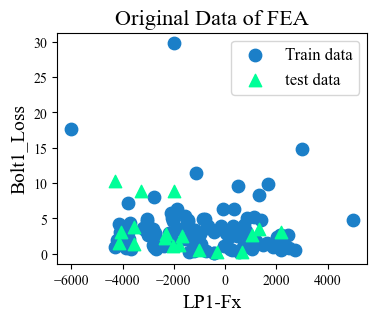

(102, 24)
(102, 4)
(18, 24)
(18, 4)
[ 2.35  3.61  0.08  0.67  2.32  3.51  3.93  4.23  0.94  2.67  0.87  0.59  1.94 11.49  3.87  3.37  6.32  7.13  6.39  2.27  1.15  3.93  5.03  4.86  9.64  0.43  3.97  4.76  2.14  2.09  3.6   0.7   1.85 29.8   0.19  4.58  2.74  8.    2.49  1.67  1.11  0.75  2.61  4.87  1.74  2.35  2.93  3.4   1.18  1.19  0.65  2.9   3.13  0.8   2.9   2.6   0.54  5.79  3.41  4.73  0.44  3.26  4.58  0.09  4.48  3.14  1.84 17.6   1.77  4.07  1.87  0.96  2.6   3.24  9.82  8.25  0.92  2.64  0.9   1.41  2.79  1.64  4.54  1.95  0.5   6.32  2.3   4.72  5.25 14.85  3.54  0.73  5.39  4.34  0.32  1.23  3.36  3.06  1.56  5.    4.9   1.33]


In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo

plt.rcParams['font.family'] = 'Times New Roman'
np.set_printoptions(suppress=True,linewidth=np.inf)
import warnings
warnings.filterwarnings('ignore')
# ✅ 1. 数据集加载与划分
data = pd.read_csv('../Loading_Results.csv')                                                            #Modified
input_names = [f'LP{i}-{d}' for i in range(1, 5) for d in ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']]
output_name = ['Bolt1_Loss','Bolt2_Loss','Bolt3_Loss','Bolt4_Loss']
train_data = data.sample(frac = 0.85,random_state=839161)                                              #**Modified**839161  886822
test_data = data.drop(train_data.index)                                                     
x_train = train_data[input_names].values
y_train = train_data[output_name].values
x_test = test_data[input_names].values
y_test = test_data[output_name].values

plt.figure(figsize=(4,3));plt.scatter(x_train[:,0],y_train[:,0],label='Train data',marker='o',color='#1B7FC8',s=80)
plt.scatter(x_test[:,0],y_test[:,0],label='test data',marker='^',color='#00FF98',s=80)
plt.xlabel(input_names[0],fontsize=14);plt.ylabel(output_name[0],fontsize=14);plt.title('Original Data of FEA',fontsize=16);plt.legend(loc='upper right',fontsize=12)
plt.show()
print(x_train.shape);print(y_train.shape);print(x_test.shape);print(y_test.shape)
print(y_train[:,0])
plot_training_trace = go.Scatter3d(
    x=x_train[:, 0].flatten(),y=x_train[:, 1].flatten(),z=y_train[:,0].flatten(),
    name='Training data (n=102)',mode='markers',
    marker=dict(size=10,color='rgba(102,102,255,1)',opacity=0.6,line=dict(color='white',width=1),)
)

plot_test_trace = go.Scatter3d(
    x=x_test[:, 0].flatten(),y=x_test[:, 1].flatten(),z=y_test[:,0].flatten(),
    name='Test data (n=18)',mode='markers',
    marker=dict(size=10,color='rgba(255, 69, 0, 1)',opacity=1,line=dict(color='violet',width=1),)
)

plot_layout = go.Layout(
    title=dict(text='Distribution of Simulated Load-Bolt Degradation Samples',x=0.32, y=0.755,xanchor='left',yanchor='top',font=dict(size=24, family='Times New Roman',color='black')),
    scene=dict(xaxis=dict(title=dict(text=input_names[1]+' (N)', font=dict(size=20, family='Times New Roman',color='black')),tickfont=dict(size=16, family='Times New Roman',color='black')),
               yaxis=dict(title=dict(text=input_names[0]+' (N)', font=dict(size=20, family='Times New Roman',color='black')),tickfont=dict(size=16, family='Times New Roman',color='black')),
               zaxis=dict(title=dict(text='Pretension force degradation of bolt 1 (%)',font=dict(size=20, family='Times New Roman',color='black')),tickfont=dict(size=16, family='Times New Roman',color='black')),
               aspectmode='cube'),
    legend=dict(x=0.6, y=0.8,bgcolor='rgba(255,255,255,0.8)',font=dict(size=20, family='Times New Roman',color='black'),bordercolor='rgba(0,0,0,0)',borderwidth=0)
)
margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
plot_data = [plot_training_trace, plot_test_trace]
plot_figure = go.Figure(data=plot_data, layout=plot_layout)
#pyo.plot(plot_figure, filename='./Fig13(b)_Bolt1Dataset.svg', auto_open=True, include_plotlyjs=True)

In [2]:
# ✅ 2. 特征扩展（多项式 + 三角函数）与标准化
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
def NL(x, DegreePoly, DegreeSin, DegreeCos):
    poly = PolynomialFeatures(degree=DegreePoly, include_bias=False)
    x_poly = poly.fit_transform(x) if DegreePoly > 0 else x
    x_sin = np.hstack([np.sin((i + 1)/146.69 * x) for i in range(DegreeSin)]) if DegreeSin > 0 else None
    x_cos = np.hstack([np.cos((i + 1)/146.69 * x) for i in range(DegreeCos)]) if DegreeCos > 0 else None
    x_final = x_poly
    if x_sin is not None:
        x_final = np.hstack([x_final, x_sin])
    if x_cos is not None:
        x_final = np.hstack([x_final, x_cos])
    return x_final

DegreePoly=2
DegreeSin=1
DegreeCos=1

x_train_polysincos=NL(x_train,DegreePoly,DegreeSin,DegreeCos)           #引入非线性特征
x_test_polysincos = NL(x_test,DegreePoly,DegreeSin,DegreeCos)           #引入非线性特诊
#标准化
Std=StandardScaler()      
x_train_polysincos_std=Std.fit_transform(x_train_polysincos)            #标准化处理
x_test_polysincos_std = Std.transform(x_test_polysincos)                #利用训练集的参数标准化
#偏置项
x_train_polysincos_std1=np.hstack([np.ones((x_train.shape[0],1)),x_train_polysincos_std])
x_test_polysincos_std1 = np.hstack([np.ones((x_test.shape[0],1)),x_test_polysincos_std])
print(x_train_polysincos_std1.shape,x_test_polysincos_std1.shape)

(102, 373) (18, 373)


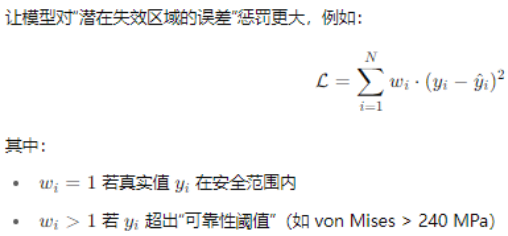

[0.05851131 0.13262201 0.00006987 0.00488896 0.05707013 0.12585326 0.15517234 0.17745257 0.00960049 0.07487935 0.00822955 0.00379324 0.04025707 0.76339294 0.15084466 0.11661231 0.35343318 0.42594008 0.35968318 0.05470456 0.01433491 0.15517234 0.24135958 0.22730545 0.63744407 0.00201664 0.15808196 0.21914722 0.04876929 0.04657028 0.13193897 0.00533538 0.03667631 0.99993843 0.00039405 0.20468246 0.07869639 0.5027847  0.06545058 0.02998946 0.01336162 0.00612238 0.07167407 0.22812584 0.03251407 0.05851131 0.08946895 0.11856894 0.01508683 0.01534164 0.0046021  0.08772862 0.10143795 0.00696297 0.08772862 0.07114588 0.00317854 0.30650117 0.11922404 0.21671634 0.00211143 0.10955046 0.20468246 0.00008843 0.1967766  0.10205284 0.03628814 0.96601594 0.03362568 0.16543983 0.03745847 0.01001129 0.07114588 0.10828574 0.65104734 0.52435583 0.00919817 0.07326899 0.00880434 0.02147159 0.08147338 0.02893728 0.20150858 0.04066459 0.0027257  0.35343318 0.05611843 0.2159078  0.25986215 0.90996855 0.1278694

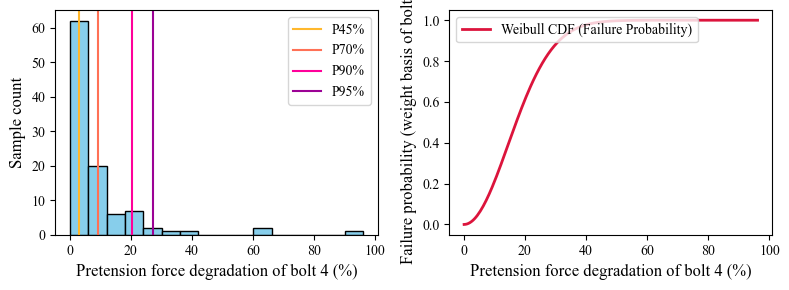

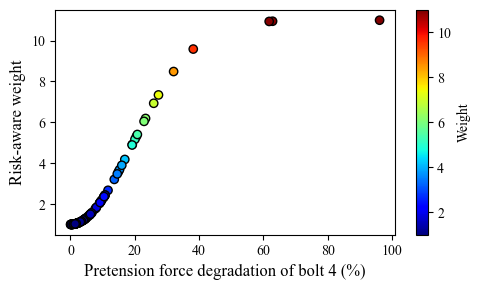

In [5]:
# ✅ 4.Risk-aware loss function 风险感知损失函数
from scipy.stats import weibull_min
# Step 1：提取应力列（假设它是第 0 列）
Degradation_bolt1 =            y_train[:,0]    #data.sample(frac=1)[output_name].values[:,0]
Degradation_bolt2 =            y_train[:,1]    #data.sample(frac=1)[output_name].values[:,1]
Degradation_bolt3 =            y_train[:,2]    #data.sample(frac=1)[output_name].values[:,2]
Degradation_bolt4 =            y_train[:,3]    #data.sample(frac=1)[output_name].values[:,3]

k1 = 2;   k2=2;   k3=2;   k4=2
λ1 = np.percentile(Degradation_bolt1, 95)
λ2 = np.percentile(Degradation_bolt2, 95)
λ3 = np.percentile(Degradation_bolt3, 95)
λ4 = np.percentile(Degradation_bolt4, 95)

weibull_CDF1 = weibull_min.cdf(Degradation_bolt1, c=k1 ,  scale=λ1)
weibull_CDF2 = weibull_min.cdf(Degradation_bolt2, c=k2 ,  scale=λ2)
weibull_CDF3 = weibull_min.cdf(Degradation_bolt3, c=k3 ,  scale=λ3)
weibull_CDF4 = weibull_min.cdf(Degradation_bolt4, c=k4 ,  scale=λ4)
print(weibull_CDF1),print(weibull_CDF2),print(weibull_CDF3),print(weibull_CDF4)

p5 = np.percentile(Degradation_bolt4, 95)   #极高风险（结构失效风险区）
p10 = np.percentile(Degradation_bolt4, 90)  #高风险 （局部破坏可能区）
p30 = np.percentile(Degradation_bolt4, 70)  #中风险（局部损伤区）
p55= np.percentile(Degradation_bolt4, 45)   #低风险（正常服役区）
print(p5,p10,p30,p55)
# Step 2：初始化权重向量
w_bolt_loss1 = (1+10 * weibull_CDF1).reshape(-1,1)
w_bolt_loss2 = (1+10 * weibull_CDF2).reshape(-1,1)
w_bolt_loss3 = (1+10 * weibull_CDF3).reshape(-1,1)
w_bolt_loss4 = (1+10 * weibull_CDF4).reshape(-1,1)

#w_stress = np.ones_like(PretensionDegradation).reshape(-1,1)
print(w_bolt_loss1.shape)
print(y_train[:,0])
print(w_bolt_loss1.T)
plt.figure(figsize=(8,3));plt.subplot(121)
plt.hist(Degradation_bolt4, bins=16, color='skyblue', edgecolor='black')
plt.axvline(p55, color='#ffb82d', label='P45%')
plt.axvline(p30, color='#ff7156', label='P70%')
plt.axvline(p10, color='#ff009a', label='P90%')
plt.axvline(p5, color="#9c0295", label='P95%')
#plt.title('Stress Distribution')
plt.xlabel('Pretension force degradation of bolt 4 (%)',fontsize=12)
plt.ylabel('Sample count',fontsize=12)
plt.legend(loc='upper right')

degradation_range = np.linspace(Degradation_bolt4.min(), Degradation_bolt4.max(), 200)
weibull_CDF_range = weibull_min.cdf(degradation_range, c=k3, scale=λ3)
# 可视化
plt.subplot(122)
plt.plot(degradation_range, weibull_CDF_range, color='crimson', lw=2, label='Weibull CDF (Failure Probability)')
plt.xlabel('Pretension force degradation of bolt 4 (%)',fontsize=12), plt.ylabel('Failure probability (weight basis of bolt 1)',fontsize=12)
#plt.title('Weibull-based Risk Weight Mapping')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig("Pretension Degradation distribution of bolt4 and CDF.svg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5,3))
sc = plt.scatter(Degradation_bolt4, w_bolt_loss4, c=w_bolt_loss4, cmap='jet', edgecolor='k')
plt.xlabel("Pretension force degradation of bolt 4 (%)",fontsize=12), plt.ylabel("Risk-aware weight",fontsize=12), #plt.title("Risk Weights Assigned to Stress Samples")
plt.colorbar(sc, label="Weight")
plt.tight_layout()
#plt.savefig("Bolt 4 Weight distribution.svg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [13]:
print(y_train[:,0:4].shape)

(102, 4)


(3)Seed found: 965------     0.9004167339345812
0.9004167339345812
[[ 0.01151147 -0.00014485  0.01492429 ... -0.00364943  0.0063915   0.01437038]
 [ 0.02113309  0.00107561  0.01444795 ... -0.00161577  0.0148903  -0.00511379]
 [ 0.00841177 -0.00448059  0.01236679 ... -0.01107018  0.00672925 -0.00511921]
 [ 0.01285119  0.00685298 -0.01229237 ...  0.0054459   0.00130486  0.00325113]]


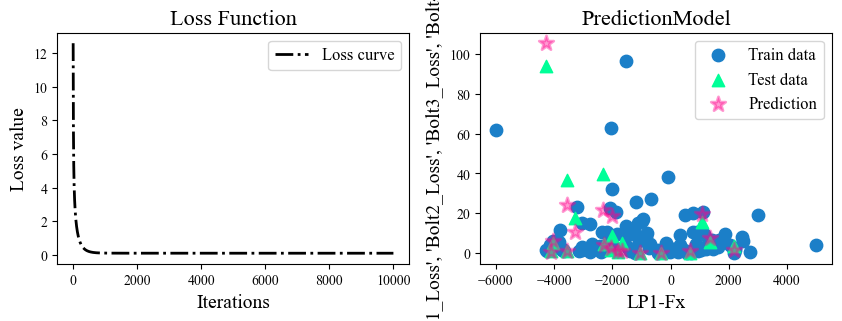

(4)Test values of results:  
 [[ 1.36  0.27  0.48  0.32  1.56  3.5   2.79  1.05  3.1   1.18  2.69  3.08  2.48  3.85  8.86 10.31  8.93  2.2 ]
 [ 0.86  0.12  0.44  0.22  1.47  6.37  7.5   0.75  6.53  0.55  4.35  0.41  0.38  2.67  8.59  0.93  2.15  0.51]
 [ 0.63  0.15  0.66  0.11  1.09  8.22 10.37  0.67  5.65  0.69 24.46  1.45  1.96 15.98 28.25 18.08  3.16  5.04]
 [ 0.95  0.09  0.32  0.13  0.85  5.74  4.61  1.51  3.44  0.7  15.65  5.25  4.89 36.69 17.66 93.72  8.61 39.54]]
(5)Predictive values of results:  
 [ 0.52664993  0.14608609  0.51496456 -0.12953772  1.066846    2.02171718  1.84111012  0.15319569  1.84310199  0.39144266  1.54325441  0.53400809  0.64784802  1.48829086  2.57411619  0.48631255  0.65475755  0.11255863]
(6)R-squared (R²_bgd):   0.9004167339345812
(7)初始损失值= 12.579956106337077 最终损失值= 0.10083834965249958
(8)Intercept: 1.2287712292711337 Weight: [-0.03645471  0.04143039 -0.0392944   0.00583551  0.01438776  0.01467579 -0.07134465 -0.03201168 -0.01126816  0.00048903 -0.004459

In [6]:
plt.figure(figsize=(10,3))
target = 0.99  # 假设你得到这个随机数（约值）
tolerance = 0.15
#Modified Seed(bolt loss--965 randn,)

for seed in np.arange(965,966):
    np.random.seed(seed)
    learning_rate=0.001                                                                                                     #Modified***初次计算机的调整
    epoch_num_bgd=10000                                                                                                      #Modified***初次计算记得调整，误差收敛，但拟合可能还不够好
    penalty=1
    sample_num_train=x_train_polysincos_std1.shape[0]
    feature_num_std=x_train_polysincos_std1.shape[1]
    theta_ml_bgd=np.random.randn(feature_num_std,4) *0.01
    theta_ml_path_bgd=[]
    #print(theta_ml_path_bgd)
    ITR=[];LOSS_bgd=[];t=0                              #损失相关参数
    for itr in range(epoch_num_bgd):
        y_predict_test_bgd=np.dot(x_test_polysincos_std1,theta_ml_bgd)
        y_predict_train_bgd=np.dot(x_train_polysincos_std1,theta_ml_bgd)#预测
        #预测误差--对数化，避免负损失
        epsilon = 0.77
        y_train_log = np.log(y_train+epsilon); y_test_log = np.log(y_test+epsilon)
        err_bolts = y_predict_train_bgd - y_train_log       #shape(N,4)
        #gradient----differentiation from loss function
        w_matrix = np.hstack([w_bolt_loss1, w_bolt_loss2, w_bolt_loss3, w_bolt_loss4])  #shape(N,4)
        gradient_obj= 2/sample_num_train * x_train_polysincos_std1.T.dot(w_matrix * err_bolts)+\
            penalty/(sample_num_train)*theta_ml_bgd
        #parameter updates
        theta_ml_bgd=theta_ml_bgd-learning_rate*gradient_obj
        theta_ml_path_bgd.append(theta_ml_bgd)
        #loss function
        t+=1;ITR.append(t)
        bolt_loss=(w_matrix *( err_bolts)**2).mean()
        cost= bolt_loss + penalty/(sample_num_train)*np.sum(theta_ml_bgd**2)
        LOSS_bgd.append(cost)  

    from sklearn.metrics import r2_score
    r2_bgd = r2_score(y_test_log[:,0:4], y_predict_test_bgd[:,0:4])
    if abs(r2_bgd - target) < tolerance:
        print(f"(3)Seed found: {seed}------     {r2_bgd}")
r2_all = r2_score(y_test_log[:, 0:4], y_predict_test_bgd[:,0:4], multioutput='uniform_average')  # 默认平均
print(r2_all)
print(theta_ml_path_bgd[0].T)
plt.subplot(121)
ITR=np.array(ITR);LOSS_bgd=np.array(LOSS_bgd);plt.plot(ITR,LOSS_bgd,'k-.',label='Loss curve',lw=2)   #损失作图
plt.xlabel('Iterations',fontsize=14);plt.ylabel('Loss value',fontsize=14)
#plt.xticks(np.arange(0,max(ITR)+1,200),fontsize=12);plt.yticks(np.arange(0,max(LOSS_bgd)+1,2),fontsize=12)
plt.legend(fontsize=12)
plt.title('Loss Function',fontsize=16)

plt.subplot(122)
plt.scatter(x_train[:,0],y_train[:,3],label='Train data',marker='o',color='#1B7FC8',s=80)
plt.scatter(x_test[:,0],y_test[:,3],label='Test data',marker='^',color='#00FF98',s=80)
plt.scatter(x_test[:,0],np.exp(y_predict_test_bgd[:,3])-epsilon,lw=2,label='Prediction',marker='*',color="#FF008C",alpha=0.4,s=120)
plt.xlabel(input_names[0],fontsize=14)
plt.ylabel(output_name,fontsize=14)
plt.title('PredictionModel',fontsize=16)
plt.legend(fontsize=12)
plt.show()

print("(4)Test values of results:  \n",y_test.T)
print("(5)Predictive values of results:  \n",y_predict_test_bgd[:,1].T)
print("(6)R-squared (R²_bgd):  ", r2_bgd)
print('(7)初始损失值=',LOSS_bgd[0],'最终损失值=',LOSS_bgd[-1])
print('(8)Intercept:',theta_ml_bgd.T[0,0],
      'Weight:',theta_ml_bgd.T[0,1:]
      ,'feature_num:',x_train.shape[1],'\nDegreePoly0=1:',DegreePoly,'DegreeSin:',DegreeSin,'DegreeCos:',DegreeCos)
#PREDICTION#####################################################################################################################################################